In [58]:
%matplotlib inline
import matplotlib

import seaborn as sns
import requests

from bs4 import BeautifulSoup
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from requests_futures.sessions import FuturesSession
import itertools  # itertools.combinations may be useful
import networkx as nx
import re

sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [59]:
link_list_physicist = 'https://en.wikipedia.org/wiki/List_of_physicists'

In [60]:
page = requests.get(link_list_physicist)

soup = BeautifulSoup(page.text, "lxml")
# print(soup)
print(soup.select('li')[1].a.get('href'))
print(soup.select('li')[1].a.get('title'))

/wiki/Jules_Aarons
Jules Aarons


In [82]:
remove_words = ['General disclaimer','Upload files', 'Category', 'List', 'list', 'About', 'about', 'File', 'Wikipedia:']
replace_words = '(physicist)'
def get_links(response):
    
    soup = BeautifulSoup(response.text, "lxml")
    link_names = []
    for i in soup.select('li'):
        try:
            link = i.a.get('href')
            if 'wiki' in link:
                name = i.a.get('title')
                
                if name != None and len(name.split())<4 and name.split()[0] in link:
                    flag = True
                    for word in remove_words:
                        if word in name:
                            print('remove because of :', word,'is in', name)
                            flag = False
                            break
                            
                    
                    if flag:
                        
                        name = name.replace('(physicist)', '')
                        
                        link_names.append([link, name])
        except:
            pass
    return link_names # A list of URL, date pairs


In [88]:
links = get_links(page)
print(len(links))

remove because of : list is in Evangelista Torricelli
remove because of : Category is in Category:Lists of scientists
remove because of : Category is in Category:Physics-related lists
remove because of : Category is in Category:Physicists
remove because of : Category is in Category:Dynamic lists
remove because of : Upload files is in Upload files [u]
remove because of : About is in Wikipedia:About
remove because of : General disclaimer is in Wikipedia:General disclaimer
941


## scarpping data from page

In [64]:
def get_rela_names(path, names):
    page = requests.get(path)
    soup = BeautifulSoup(page.text, "lxml")
    rela_names = []
    
    
    for name in names:
        if name in soup.get_text():
            rela_names.append(name)
    return [rela_names]

## uncomment to scrap data from all page (in here I load the result from physicsist_net.npy) 

In [65]:
# # Scraping all of the pages could take 10 minutes or so.
# all_links = np.array(links)[:,0]
# names = np.array(links)[:,1]
# clean_captions = []
# for i,path in enumerate(all_links):
#     path_i = 'https://en.wikipedia.org/' + path
#     captions = get_rela_names(path_i, names)
    
#     clean_captions.extend(captions)
# #     print(names[i], captions)
#     if i%10==0:
#         print("counting", i)


In [7]:
#np.save('physicsist_net', clean_captions)

clean_captions = np.load('physicsist_net.npy',allow_pickle=True)

## make network use networkx

In [8]:
def make_network(s):
    G = nx.Graph()
    
    for i,clist in enumerate(s):
              
        for pair in itertools.combinations(clist,2):
    
            G.add_node(pair[0])
            G.add_node(pair[1])
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]['weight'] += 1

            else:
                G.add_edge(*pair, weight = 1)
   
    print(i)
    print('pairs:', len(G.edges()))
    print('nodes:', len(G.nodes()))
    return G


In [249]:
# clean_captions

In [238]:
print(len(clean_captions))
G = make_network(clean_captions)
# G.nodes

941
940
pairs: 37686
nodes: 797


In [239]:
f = G.copy()
for i in G.nodes():
#     print(i)
    if G.degree[i] < 100:
        f.remove_node(i)
deg = dict(f.degree(weight = 'weight'))

In [240]:
for edge in f.edges:
    if f[edge[0]][edge[1]]['weight']<10:
        f.remove_edge(*edge)


In [241]:
len(f.edges())


3883

In [242]:
pr = nx.pagerank(G,alpha=0.85) ## calculate pagerank

In [243]:
import operator
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
pagerank = list(sorted_pr)[-100:][::-1]

In [244]:
# print(pagerank)

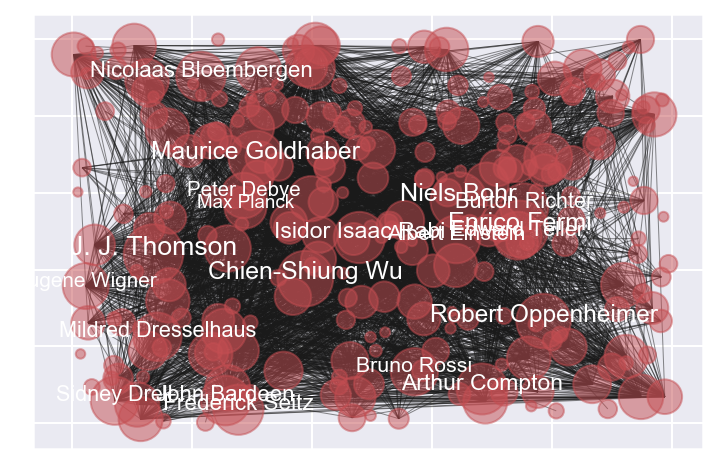

In [263]:

pos = nx.random_layout(f)

connection = dict(f.degree)
# print(deg)
nx.draw_networkx(f, pos, with_labels= False,\
                node_color='r', edgelist=f.edges(),\
                width=0.5, alpha=0.5, node_size=[v*0.2 for v in deg.values()])#)

for i in np.array(pagerank)[:,0][:20]:
    plt.annotate(i, pos[i],  color = 'w', size = np.sqrt(deg[i])/5, ha='center')

plt.savefig('physicists.png')
plt.show()

## generate search links from google.com

In [106]:
wiki_links = []
all_links = np.array(links)
for j in list(f.nodes()): 

    link = all_links[np.where(all_links[:,1]==j)][0][0]
    
    wiki_links += ['https://en.wikipedia.org' + link]
#     print(wiki_links)


In [119]:
# wiki_links


## plot using bokeh

In [108]:
# G=nx.karate_club_graph()
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool,\
BoxSelectTool, BoxZoomTool, ResetTool,ColumnDataSource,OpenURL

from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Category10



In [109]:
c1 = Category10[3][1]
c2 = Category10[3][2]
c3 = Category10[3][0]

In [160]:
pos = nx.random_layout

In [162]:


plot = figure(title="Tap node: direct to wikipedia",x_range=(-0.1, 1.1), y_range=(-0.1, 1.1),
              tools="tap, pan,wheel_zoom,box_zoom,reset",\
              plot_width=800, plot_height=500)
graph = from_networkx(f, pos, center=(0,0))

graph.edge_renderer.glyph = MultiLine(line_color="#000000", line_alpha=0.5, line_width=1)
graph.edge_renderer.selection_glyph = MultiLine(line_color=c2, line_width=2)
graph.edge_renderer.hover_glyph = MultiLine(line_color=c3, line_width=2)

graph.node_renderer.glyph = Circle(size=10, fill_color=c1, fill_alpha = 0.5, line_width=0)
graph.node_renderer.selection_glyph = Circle(size=10, fill_color=c2)
graph.node_renderer.hover_glyph = Circle(size=10, fill_color=c3)


graph.selection_policy = NodesAndLinkedEdges()
graph.inspection_policy = NodesAndLinkedEdges()



In [149]:
print(len(links))

941


In [150]:
Category10[3][0]

'#1f77b4'

In [151]:
node_size=[np.sqrt(v) for v in deg.values()]
index = list(f.nodes())
color = [Category10[3][1]]*len(node_size)
print(len(node_size))
# node_hover_tool = HoverTool(tooltips=[("index", "@index")])


427


In [152]:

node_source = ColumnDataSource(data=dict(index=list(f.nodes()),
                                degrees = list(deg.values()),
                                connections = list(connection.values()),
                                         
                                node_size = list(node_size),
                                color = color,
                                wiki_links = wiki_links,   
                                label=list(f.nodes()),
                                        
                                        ))


In [176]:

graph.node_renderer.glyph.size = {'field': 'node_size'}
graph.node_renderer.glyph.fill_color = {'field': 'color'}
plot.renderers.append(graph)
graph.node_renderer.data_source.data = node_source.data
node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("degree", "@degrees"), ("connections", "@connections")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

url = "@wiki_links"
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)


In [177]:
labels = LabelSet(x='weight', y='height', text='index', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')



# plot.add_layout(labels)



In [248]:

output_file("networkx_graph_phys.html")
show(plot)